In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [ ]:
df = pd.read_csv('/content/train_all_tasks.csv', encoding='ISO-8859-1')

# rename the columns
df = df[['label_sexist','text','label_category']]
df.rename(columns={ 'text':'message','label_sexist':'label', 'label_category':'category'}, inplace=True)
df.head()

,label,message,category
0,not sexist,"Damn, this writing was pretty chaotic",none
1,not sexist,"Yeah, and apparently a bunch of misogynistic v...",none
2,not sexist,How the FUCK is this woman still an MP!!!???,none
3,not sexist,Understand. Know you're right. At same time I ...,none
4,not sexist,Surprized they didn't stop and rape some women,none


In [ ]:
df.describe()

,label,message,category
count,14000,14000,14000
unique,2,13999,5
top,not sexist,#NAME?,none
freq,10602,2,10602


In [ ]:
df.groupby('label').describe().T

label                                       not sexist  \
message  count                                   10602   
         unique                                  10602   
         top     Damn, this writing was pretty chaotic   
         freq                                        1   
category count                                   10602   
         unique                                      1   
         top                                      none   
         freq                                    10602   

label                                                       sexist  
message  count                                                3398  
         unique                                               3398  
         top     just the inside of your wallet: cash, bank car...  
         freq                                                    1  
category count                                                3398  
         unique                                                  4  
         top                                         2. derogation  
         freq                                                 1590

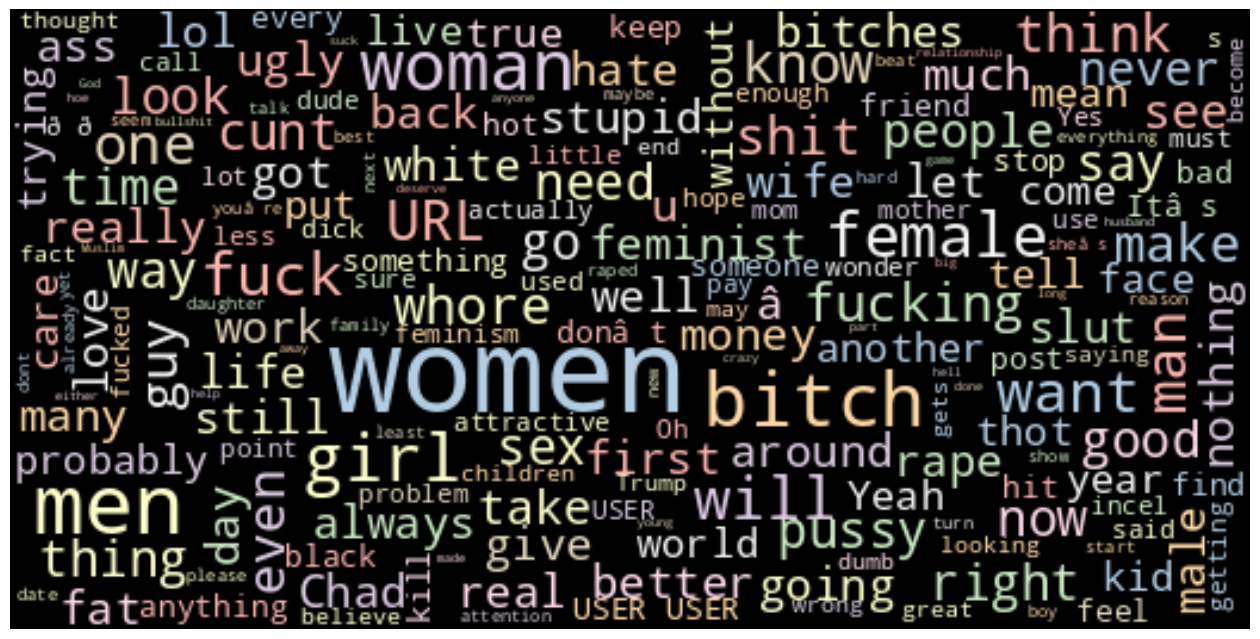

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Extracting text of sexist messages
sexist_msg_text = " ".join(df[df['label'] == 'sexist']['message'])

# Generating WordCloud
sexist_msg_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50, background_color="black", colormap='Pastel1').generate(sexist_msg_text)

# Plotting WordCloud
plt.figure(figsize=(16, 10))
plt.imshow(sexist_msg_cloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()


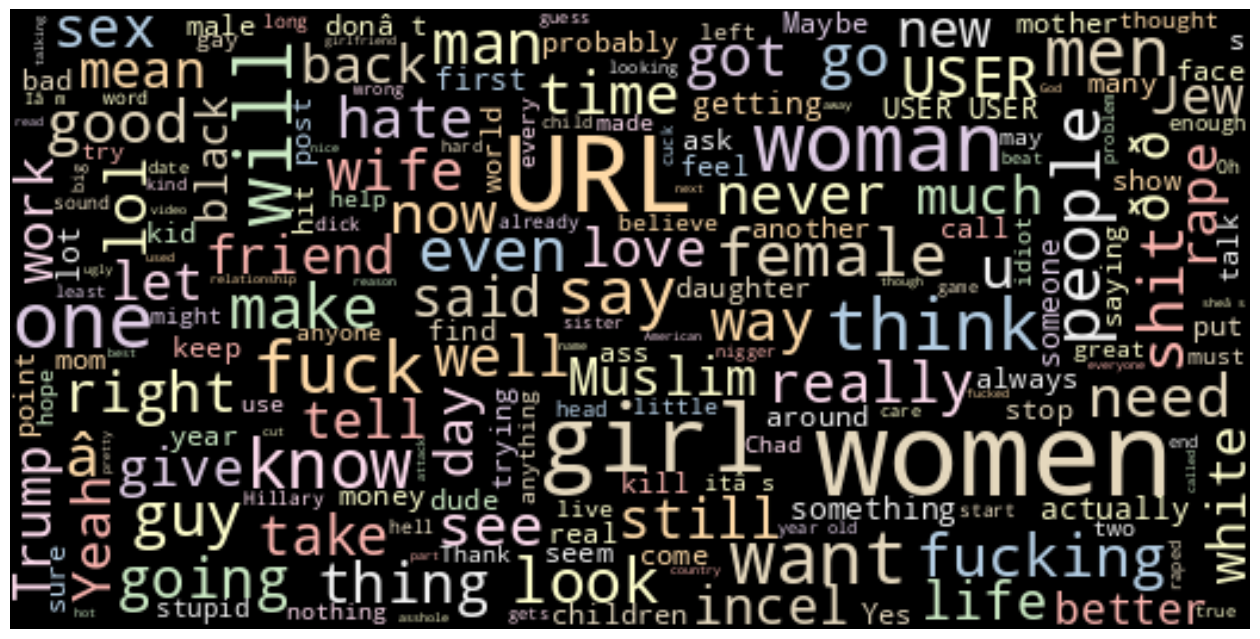

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Extracting text of sexist messages
not_sexist_msg_text = " ".join(df[df['label'] == 'not sexist']['message'])

# Generating WordCloud
not_sexist_msg_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, max_font_size=50, background_color="black", colormap='Pastel1').generate(not_sexist_msg_text)

# Plotting WordCloud
plt.figure(figsize=(16, 10))
plt.imshow(not_sexist_msg_cloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.show()


Text(0.5, 1.0, 'The distribution of sexist and not sexist messages')

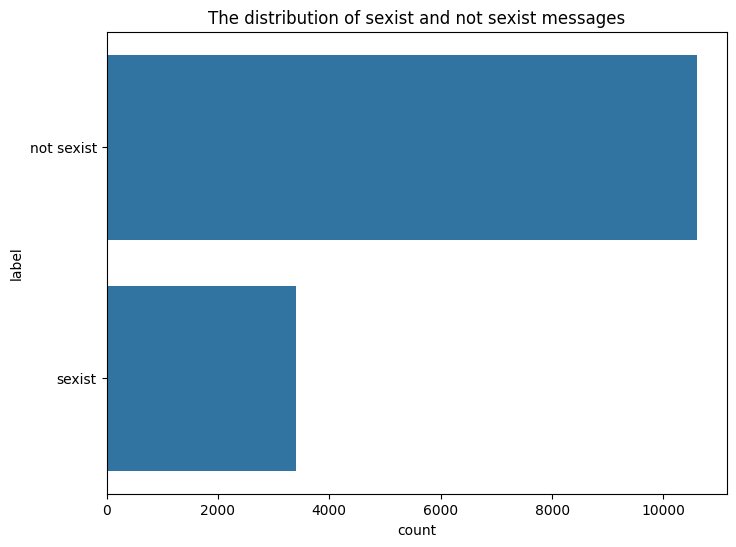

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(df.label)
plt.title('The distribution of sexist and not sexist messages')

In [ ]:
# downsample the ham msg
not_sexist_msg = df[df['label'] == 'not sexist']
sexist_msg = df[df['label'] == 'sexist']

not_sexist_msg_df = not_sexist_msg.sample(n = len(sexist_msg), random_state = 44)
sexist_msg_df = sexist_msg



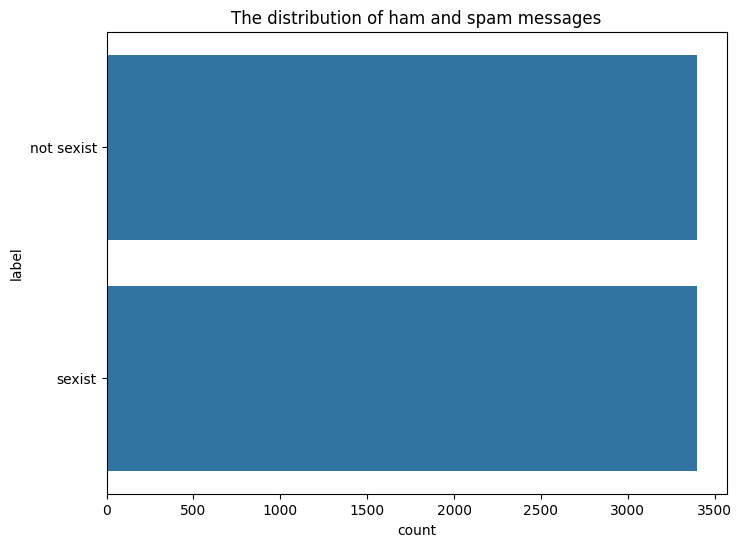

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have defined not_sexist_msg_df and sexist_msg_df

# Concatenating downsampled ham messages and spam messages
balanced_df = pd.concat([not_sexist_msg_df, sexist_msg_df])

# Plot the distribution of ham and spam messages
plt.figure(figsize=(8, 6))
sns.countplot(balanced_df['label'])
plt.title('The distribution of ham and spam messages')
plt.show()


In [ ]:
# Get length column for each text
balanced_df['text_length'] = balanced_df['message'].apply(len)

# Map label to numerical values
balanced_df['msg_type'] = balanced_df['label'].map({'not sexist': 0, 'sexist': 1})

# Extract the message labels
msg_label = balanced_df['msg_type'].values

# Display the updated DataFrame
balanced_df.head()


,label,message,category,text_length,msg_type
6372,not sexist,Who has more star power: the Warriors or the E...,none,64,0
8599,not sexist,And im her looksmatch too if not better lookin...,none,199,0
1818,not sexist,#HillarysAltRightSpeech is giving the alt righ...,none,135,0
10618,not sexist,My WIFEs persuasive argument paper in English ...,none,197,0
10051,not sexist,I am talking about desire and crushes - the em...,none,186,0


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(balanced_df['message'], balanced_df['msg_type'], test_size=0.2, random_state=434)


In [ ]:
# Defining pre-processing parameters
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

13218

In [ ]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (5436, 50)
Shape of testing tensor:  (1360, 50)


 Dense **Model**

In [ ]:
# Define parameter
vocab_size = 500
embedding_dim = 16
drop_value = 0.2
n_dense = 24
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))


from tensorflow.keras.layers import Dropout

# Example of adding dropout regularization
dropout_rate = 0.2  # Example dropout rate
model.add(Dropout(dropout_rate))

In [ ]:
from sklearn.metrics import classification_report

# Predicting probabilities on the test set
y_pred_prob = model.predict(testing_padded)

# Converting probabilities to binary values (0 or 1) based on threshold 0.5
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Flatten y_test if needed
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = y_test.argmax(axis=1)

# Generating classification report
report = classification_report(y_test, y_pred_binary)

print("Classification Report:")
print(report)


43/43 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.87      0.74       663
           1       0.81      0.55      0.65       697

    accuracy                           0.70      1360
   macro avg       0.73      0.71      0.70      1360
weighted avg       0.73      0.70      0.70      1360



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
 dropout_1 (Dropout)         (None, 1)                 0         
                                                        

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
170/170 - 3s - loss: 2.0091 - accuracy: 0.5239 - val_loss: 0.7120 - val_accuracy: 0.4875 - 3s/epoch - 19ms/step
Epoch 2/30
170/170 - 1s - loss: 2.0452 - accuracy: 0.5576 - val_loss: 0.6963 - val_accuracy: 0.4875 - 756ms/epoch - 4ms/step
Epoch 3/30
170/170 - 1s - loss: 2.1156 - accuracy: 0.6093 - val_loss: 0.6796 - val_accuracy: 0.5441 - 890ms/epoch - 5ms/step
Epoch 4/30
170/170 - 1s - loss: 2.0257 - accuracy: 0.6542 - val_loss: 0.6645 - val_accuracy: 0.5860 - 709ms/epoch - 4ms/step
Epoch 5/30
170/170 - 1s - loss: 1.9547 - accuracy: 0.6797 - val_loss: 0.6268 - val_accuracy: 0.6618 - 605ms/epoch - 4ms/step
Epoch 6/30
170/170 - 1s - loss: 2.0382 - accuracy: 0.6911 - val_loss: 0.6181 - val_accuracy: 0.6713 - 573ms/epoch - 3ms/step
Epoch 7/30
170/170 - 1s - loss: 1.9643 - accuracy: 0.7005 - val_loss: 0.6008 - val_accuracy: 0.6949 - 1s/epoch - 6ms/step
Epoch 8/30
170/170 - 1s - loss: 1.9445 - accuracy: 0.7029 - val_loss: 0.5917 - val_accuracy: 0.7000 - 1s/epoch - 7ms/step
Epoch 9/

In [ ]:
model.evaluate(testing_padded, y_test)

43/43 [==============================] - 0s 3ms/step - loss: 0.5939 - accuracy: 0.7029


[0.5939326882362366, 0.7029411792755127]

In [ ]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

22/22 - 1s - loss: 0.5286 - accuracy: 0.7601 - 752ms/epoch - 34ms/step
6/6 - 0s - loss: 0.5939 - accuracy: 0.7069 - 54ms/epoch - 9ms/step
Train accuracy: 76.01
Valid accuracy: 70.69


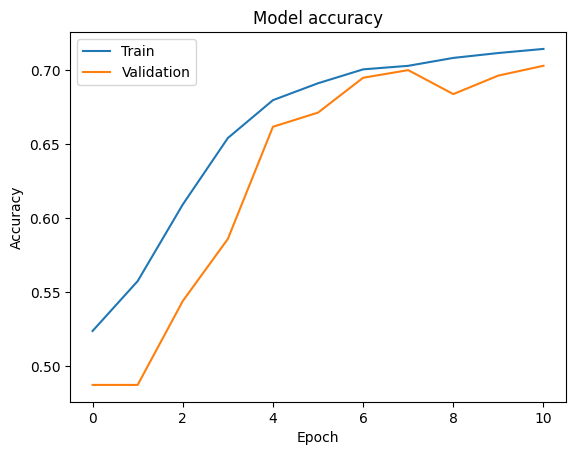

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


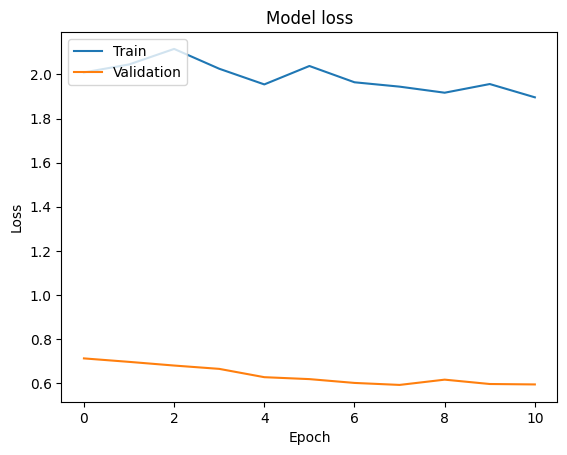

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


***Long Short Term Memory (LSTM)***


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SpatialDropout1D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Assuming balanced_df is already defined and contains 'message' and 'msg_type' columns

from tensorflow.keras.layers import Dropout



# Splitting data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(balanced_df['message'], balanced_df['msg_type'], test_size=0.2, random_state=434)

# Defining pre-processing parameters
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

# Tokenizing and padding sequences
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
total_words = len(word_index)
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

# Defining model parameters
n_lstm = 128
drop_lstm = 0.2
embedding_dim = 16  # Assuming you want to use a specific embedding dimension

# Define LSTM Model
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))


# Example of adding dropout regularization
dropout_rate = 0.2  # Example dropout rate
model1.add(Dropout(dropout_rate))

# Compile model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)


Epoch 1/30
170/170 - 14s - loss: 2.1181 - accuracy: 0.5035 - val_loss: 0.7134 - val_accuracy: 0.4875 - 14s/epoch - 81ms/step
Epoch 2/30
170/170 - 10s - loss: 2.1208 - accuracy: 0.5164 - val_loss: 0.7247 - val_accuracy: 0.4875 - 10s/epoch - 61ms/step
Epoch 3/30
170/170 - 9s - loss: 2.1523 - accuracy: 0.5158 - val_loss: 0.6497 - val_accuracy: 0.6368 - 9s/epoch - 55ms/step
Epoch 4/30
170/170 - 10s - loss: 2.0900 - accuracy: 0.5763 - val_loss: 0.7171 - val_accuracy: 0.5125 - 10s/epoch - 58ms/step
Epoch 5/30
170/170 - 10s - loss: 2.0214 - accuracy: 0.6593 - val_loss: 0.6314 - val_accuracy: 0.6912 - 10s/epoch - 61ms/step
Epoch 6/30
170/170 - 10s - loss: 2.1105 - accuracy: 0.6784 - val_loss: 0.6049 - val_accuracy: 0.6860 - 10s/epoch - 61ms/step
Epoch 7/30
170/170 - 9s - loss: 1.9671 - accuracy: 0.7084 - val_loss: 0.5941 - val_accuracy: 0.7132 - 9s/epoch - 54ms/step
Epoch 8/30
170/170 - 11s - loss: 1.9223 - accuracy: 0.7031 - val_loss: 0.5996 - val_accuracy: 0.7088 - 11s/epoch - 63ms/step
Epoc

In [ ]:
train_lstm_results = model1.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_lstm_results = model1.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_lstm_results[1]*100:.2f}')
print(f'Valid accuracy: {valid_lstm_results[1]*100:.2f}')

22/22 - 2s - loss: 0.6938 - accuracy: 0.4969 - 2s/epoch - 94ms/step
6/6 - 1s - loss: 0.6930 - accuracy: 0.5125 - 699ms/epoch - 116ms/step
Train accuracy: 49.69
Valid accuracy: 51.25


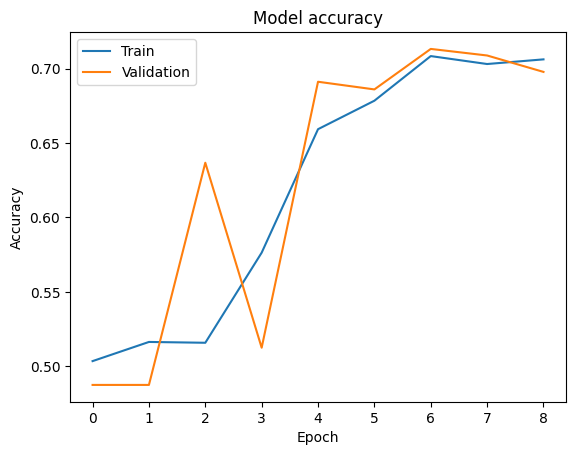

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


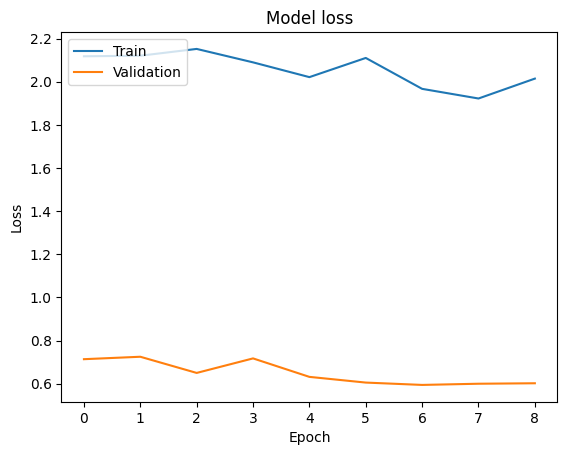

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
predict_msg = ["ALL girls are bitches",
               "she is pretty"]
def predict_spam(predict_msg):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model.predict(padded))
predict_spam(predict_msg)

1/1 [==============================] - 0s 87ms/step


array([[0.68693405],
       [0.28706035]], dtype=float32)

In [ ]:
predict_msg = ["ALL girls are bitches",
               "she is pretty"]
def predict_spam(predict_msg):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model1.predict(padded))
predict_spam(predict_msg)

1/1 [==============================] - 0s 410ms/step


array([[0.51520944],
       [0.5152095 ]], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report

# Predicting probabilities on the test set
y_pred_prob = model1.predict(testing_padded)

# Converting probabilities to binary values (0 or 1) based on threshold 0.5
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Flatten y_test if needed
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = y_test.argmax(axis=1)

# Generating classification report
report = classification_report(y_test, y_pred_binary)

print("Classification Report:")
print(report)


43/43 [==============================] - 2s 42ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       663
           1       0.51      1.00      0.68       697

    accuracy                           0.51      1360
   macro avg       0.26      0.50      0.34      1360
weighted avg       0.26      0.51      0.35      1360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
